In [ ]:
pip install numpy

In [ ]:
pip install mysql-connector-python

In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),  
    ('order_items.csv', 'order_items')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='12345',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'D:\Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "12345",
                            database = "ecommerce")

cur = db.cursor()

In [ ]:
----------------------------------------------Basic----------------------------------------------------------------

#  List all unique cities where customers are located.      

In [6]:
query = """ select distinct customer_city from customers"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [17]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)

data = cur.fetchall()

"total count of orders in 2017", data[0][0]

('total count of orders in 2017', 180404)

# Find the total sales per category.

In [25]:
query = """select products.product_category as product_categorys , sum(payments.payment_value) as value
from products
join order_items on products.product_id = order_items.product_id
join payments on order_items.order_id = payments.order_id
group by product_categorys 
order by value desc """

cur.execute(query)

data=cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "Sales"])
df

,Category,Sales
0,bed table bath,3.425107e+06
1,HEALTH BEAUTY,3.314746e+06
2,computer accessories,3.170661e+06
3,Furniture Decoration,2.860353e+06
4,Watches present,2.858433e+06
...,...,...
69,PC Gamer,4.348860e+03
70,House Comfort 2,3.421080e+03
71,cds music dvds,2.398860e+03
72,Fashion Children's Clothing,1.571340e+03


# Calculate the percentage of orders that were paid in installments.

In [30]:
query = """select  sum(CASE WHEN payment_installments >= 1 THEN 1 else 0 end)/count(*)*100 from payments"""
cur.execute(query)
data = cur.fetchall()
data

[(Decimal('99.9981'),)]

# Count the number of customers from each state.

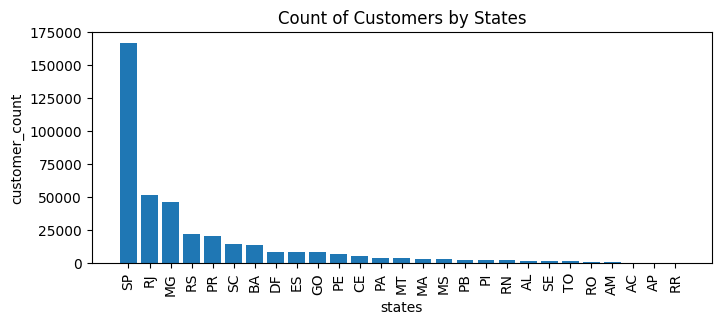

In [39]:
query =  """ select customer_state ,count(customer_id)
from customers group by customer_state
"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()


*---------------------------------------------------Intermidate-----------------------------------------------------------------

# Calculate the number of orders per month in 2018.

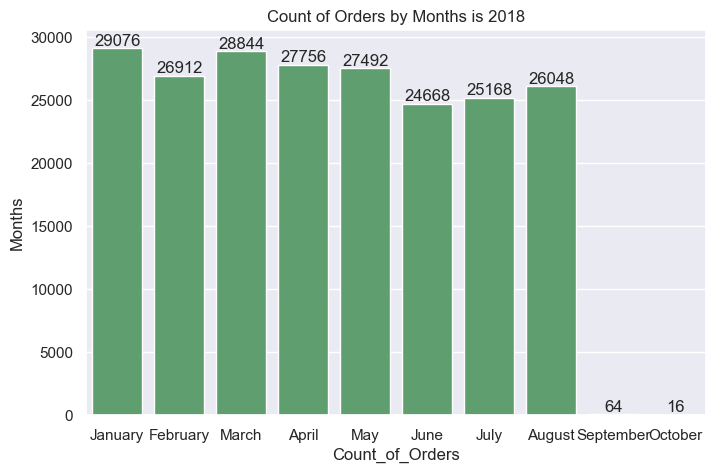

In [74]:
query = """select count(order_id) as numbers_of_orders,monthname(order_purchase_timestamp) as months 
from orders
where year(order_purchase_timestamp) = 2018
group by  months 
order by numbers_of_orders desc"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ["Months","Count_of_Orders"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["Count_of_Orders"],y = df["Months"] , data = df , order = o , color ='g')
ax.bar_label(ax.containers[0])
sns.set(rc={'figure.figsize':(8,5)})
plt.title("Count of Orders by Months is 2018")

plt.show()      


# Find the average number of products per order, grouped by customer city.

In [76]:
query = """with avg_per_order as(
select orders.order_id , orders.customer_id , count(order_items.order_id) as avg_per_order
from orders 
join order_items on orders.order_id = order_items.order_id
group by orders.order_id , orders.customer_id)

select customers.customer_city,round(avg(avg_per_order),2)as avg_number_of_orders
from customers
join avg_per_order on customers.customer_id = avg_per_order.customer_id
group by customers.customer_city"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head(10)

,0,1
0,treze tilias,5.09
1,indaial,4.46
2,sao jose dos campos,4.55
3,sao paulo,4.62
4,porto alegre,4.70
5,santos,4.65
6,sao francisco do sul,4.94
7,sao vicente,4.36
8,joinville,4.41
9,sao vendelino,4.00


#  Calculate the percentage of total revenue contributed by each product category.

In [78]:
query = """select products.product_category as product_categorys ,
 (sum(payments.payment_value)/(select sum(payment_value) from payments))*100 as total_revenue_by_each_products
from products
join order_items on products.product_id = order_items.product_id
join payments on order_items.order_id = payments.order_id
group by product_categorys 
order by total_revenue_by_each_products"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head(5)

,0,1
0,insurance and services,0.004054
1,Fashion Children's Clothing,0.009815
2,cds music dvds,0.014985
3,House Comfort 2,0.021370
4,PC Gamer,0.027165


# Identify the correlation between product price and the number of times a product has been purchased.

In [80]:
query = """select products.product_category , count(order_items.order_id) as number_of_orders,
round(avg(order_items.price),2) as product_price
from order_items
join products on order_items.product_id = products.product_id
group by products.product_category"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df.head(10)

,0,1,2
0,HEALTH BEAUTY,19340,130.16
1,sport leisure,17282,114.34
2,Cool Stuff,7592,167.36
3,computer accessories,15654,116.51
4,Watches present,11982,201.14
5,housewares,13928,90.79
6,electronics,5534,57.91
7,None,3206,112.00
8,toys,8234,117.55
9,bed table bath,22230,93.30


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [82]:
query = """with rank_by_revenue_gen as (
	select p.product_category as product_categorys , s.seller_id as seller,
		(sum(pay.payment_value) / (select sum(payment_value) from payments) * 100)  as total_revenue_by_each_seller
	from products p
	join order_items  oi on p.product_id = oi.product_id
	join payments pay on oi.order_id = pay.order_id
	join sellers s on oi.seller_id = s.seller_id
	group by p.product_category ,  s.seller_id )


select product_categorys,seller,total_revenue_by_each_seller,
Dense_RANK() over(partition by product_categorys order by total_revenue_by_each_seller desc ) as ranks_by_revenue
from  rank_by_revenue_gen
 order by product_categorys , ranks_by_revenue"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head(10)

,0,1,2,3
0,None,c826c40d7b19f62a09e2d7c5e7295ee2,1.390359,1
1,None,1ca7077d890b907f89be8c954a02686a,0.431145,2
2,None,5d378b73ab7dd6f0418d743e5dcb0bd1,0.340718,3
3,None,46dc3b2cc0980fb8ec44634e21d2718e,0.281172,4
4,None,897060da8b9a21f655304d50fd935913,0.201439,5
5,None,abe021b01ba992245271b9aa422032df,0.170836,6
6,None,e5a3438891c0bfdb9394643f95273d8e,0.118203,7
7,None,17306570e772e7718c92a562d33f5f1d,0.096825,8
8,None,2eb70248d66e0e3ef83659f71b244378,0.094760,9
9,None,0c8380b62e38e8a1e6adbeba7eb9688c,0.090472,10


-----------------------------------------Advanced--------------------------------------------------------------

# Identify the top 3 customers who spent the most money in each year.

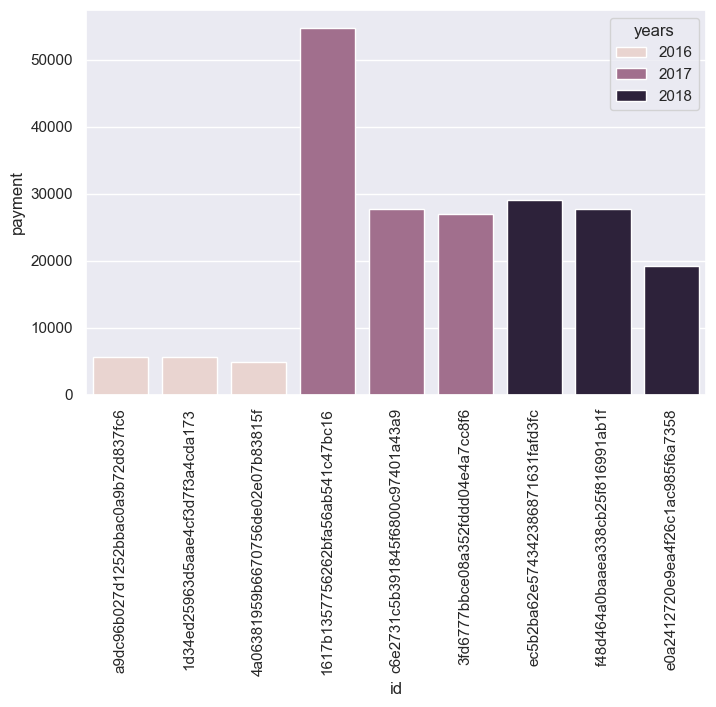

In [83]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()

# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase. 

In [84]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# Calculate the cumulative sales per month for each year.

In [85]:

query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56
